# Corona Timelines - Analysis for Germany

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as pyplot

In [2]:
# changeme
START_DATE='07-mar-2020'

## Statistics and Timeline Data

In [3]:
MEAN_INCUBATION_TIME=6 #days

# see https://www.bundesregierung.de/breg-de/themen/coronavirus/coronavirus-1725960
EVENTS = {
    'KONTAKT_SPERRE_DATE':'23-mar-2020',
    'BAR_CLUB_GYM_SHUTDOWN_DATE':'16-mar-2020',
    'BORDERS_CLOSED_DATE':'15-mar-2020',
    'ESCALATION_EVENTS_LESS_1000_DATE':'10-mar-2020'
}

In [4]:
fed_inhabitants = pd.read_csv('./data/german-federation-stats.csv',thousands='.', decimal=',')
fed_inhabitants_2018 = fed_inhabitants[['Bundesland','2018']].rename(columns={'2018':'inhabitants_2018'})

## Current Corona Data

In [5]:
CURRENT_DATA_URL='https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/data/Coronavirus.current.v2.csv'
HISTORY_DATA_URL='https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/data/Coronavirus.history.v2.csv'

In [6]:
df = pd.read_csv(HISTORY_DATA_URL)
df['date'] = pd.to_datetime(df['date'])
history_df = df[df.date>pd.to_datetime(START_DATE)]

# German Data

In [7]:
#history_df.parent.unique()
#history_df.label.unique()

In [8]:
de_history_df = history_df.loc[history_df.parent=='Deutschland',['label','date','recovered','confirmed','deaths']]

In [9]:
de_history_df['active'] = de_history_df['confirmed'] - (de_history_df['recovered'] + de_history_df['deaths'])

In [10]:
de_by_date = de_history_df.groupby('date').sum()

## Absolute German Cases

In [11]:
def plot_events(ax, ypos):
    for event, event_date in EVENTS.items():
        ax.axvline(event_date, color="blue", linestyle="--")
        pyplot.text(event_date,ypos,event,rotation=90)

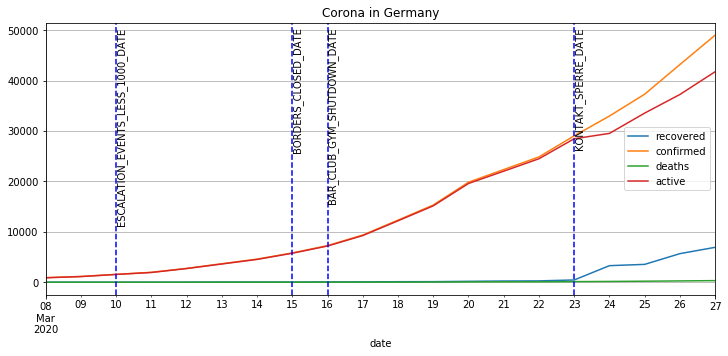

In [12]:
ax=de_by_date.plot(figsize=(12,5), title='Corona in Germany')
plot_events(ax, de_by_date.confirmed.max())
pyplot.grid(True);

## Absolute Growth

### Utilities

In [13]:
def abs_growth_from(df_by_date):
    return df_by_date.diff().fillna(0)

def plot_abs_growth(df_abs_growth,details="", max_y=None):
    max_y = max_y if max_y else df_abs_growth.max().max()
    ax = df_abs_growth.plot(figsize=(12,4), title='Absolute Confirmed Growth (1st derivate):'+details, ylim=(0,max_y))
    pyplot.ylabel('Delta to day before');
    pyplot.grid(True)
    return ax
    
def plot_abs_growth_confirmed(df_abs_growth,details=""):
    df_confirmed=df_abs_growth['confirmed']
    df = pd.DataFrame({'confirmed':df_confirmed, 'incubated':df_confirmed.shift(-MEAN_INCUBATION_TIME)})
    ax = df.plot(figsize=(12,4), title='Absolute Growth (1st derivate):'+details)
    pyplot.ylabel('Delta to day before');
    pyplot.grid(True)    
    return ax

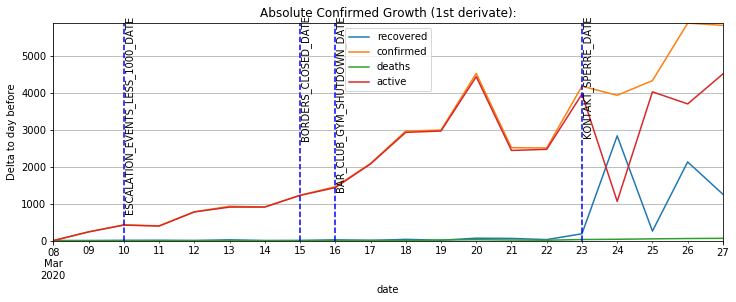

In [14]:
abs_growth_de_by_date = abs_growth_from(de_by_date)
ax = plot_abs_growth(abs_growth_de_by_date)
plot_events(ax, abs_growth_de_by_date.max().max()-10)

## Growth Factor


<img src="./growth-factor.png" width="500px">Growth Factor</img>

see [Kaggle contribution of dferhadi](https://www.kaggle.com/dferhadi/covid-19-growth-factor-visualization-and-calculus)

> the growth factor can be used to estimate the lifespan of the growth. 
> When the growth factor for the spread is 1.0 this can be a sign that we have hit the inflection point.

> ... The inflection point is where the curve changes concavity.

### Utilities

In [15]:
def growth_factor_from(confirmed_df):
    growth_confirmed = confirmed_df
    return (growth_confirmed['confirmed'] / growth_confirmed.shift(1)['confirmed'])
    
def plot_growth_factor(growth_factor_series, details=""):
    ax = growth_factor_series.plot(figsize=(12,4), linestyle=':', linewidth=2, title='Growth Factor Confirmed (2nd derivate):' + details)
    ax.axhline(y=1, color='red', linestyle='--')
    pyplot.grid(True)
    pyplot.ylabel('Delta today/Delta day before');
    return ax

In [16]:
growth_factors = growth_factor_from(abs_growth_from(de_by_date)[['confirmed']])
max_growth = growth_factors[growth_factors<10000].max()

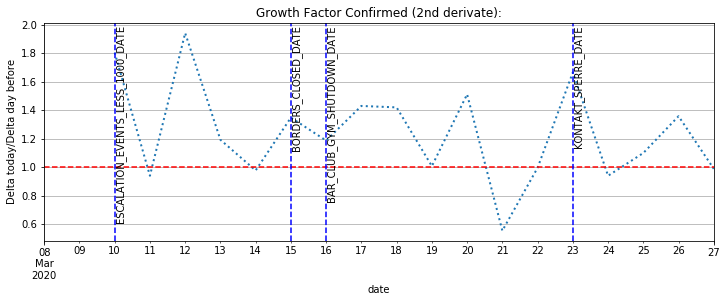

In [17]:
ax = plot_growth_factor(growth_factors)
plot_events(ax, max_growth)

# German Federal States

### Some data cleanup

In [18]:
de_fed_by_date_all = de_history_df.groupby(['date','label']).sum().reset_index()
#feds = list(de_fed_by_date_all.label.unique())
feds = ['Baden-Württemberg',
 'Bayern',
 'Berlin',
 'Brandenburg',
 'Bremen',
 'Hamburg',
 'Hessen',
 'Mecklenburg-Vorpommern',
 'Niedersachsen',
 'Nordrhein-Westfalen',
 'Repatriierte',
 'Rheinland-Pfalz',
 'Saarland',
 'Sachsen',
 'Sachsen-Anhalt',
 'Schleswig-Holstein',
 'Thüringen',
 'nicht zugeordnet']
#feds.remove('Repatriierte')

de_fed_by_date = de_fed_by_date_all[de_fed_by_date_all.label.isin(feds)]

## Absolute Cases

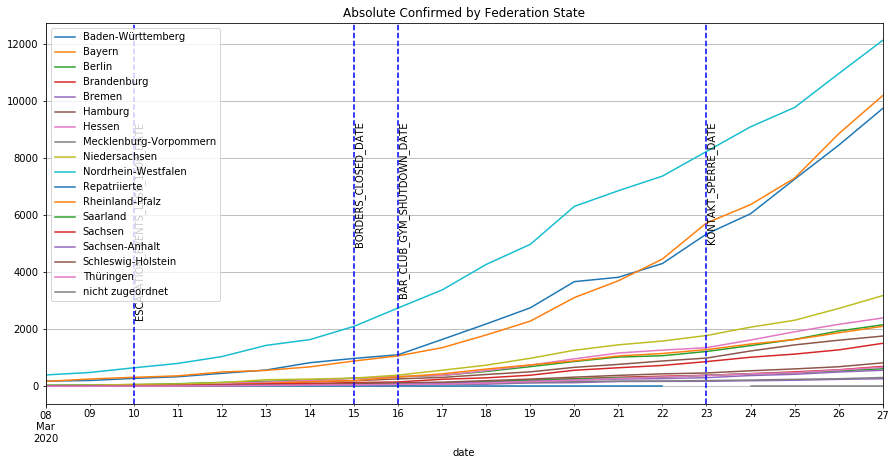

In [19]:
de_fed_by_date.set_index(['date']).groupby('label')['confirmed'].plot(figsize=(15,7), legend=True, title='Absolute Confirmed by Federation State')
plot_events(pyplot.gca(),9000)
pyplot.grid(True);

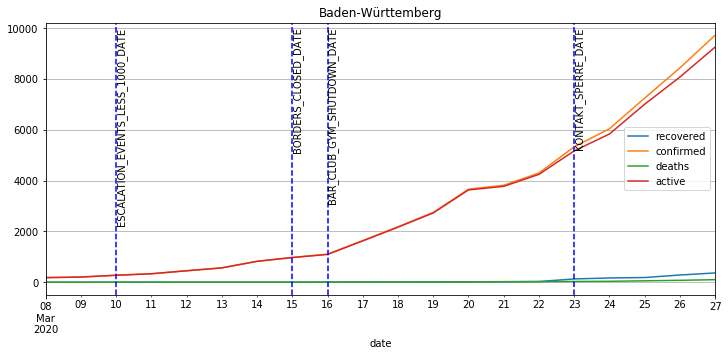

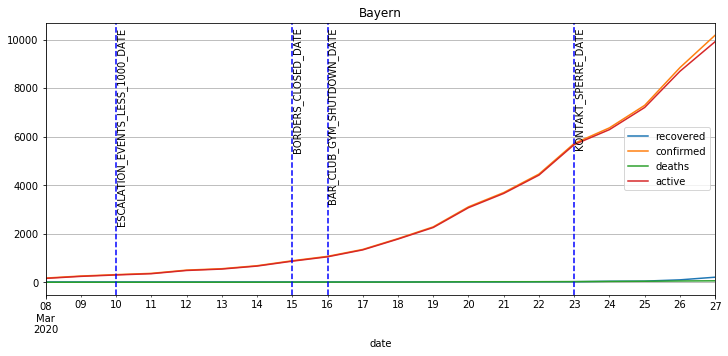

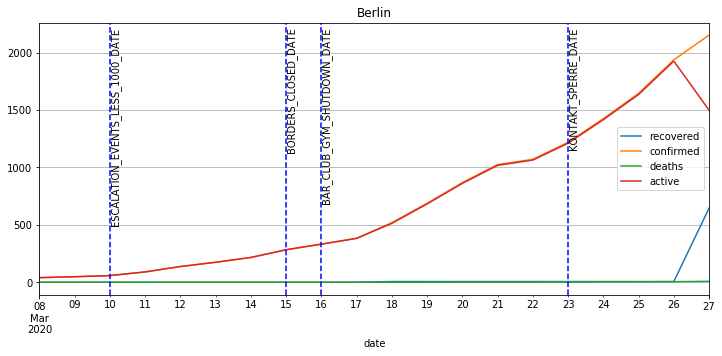

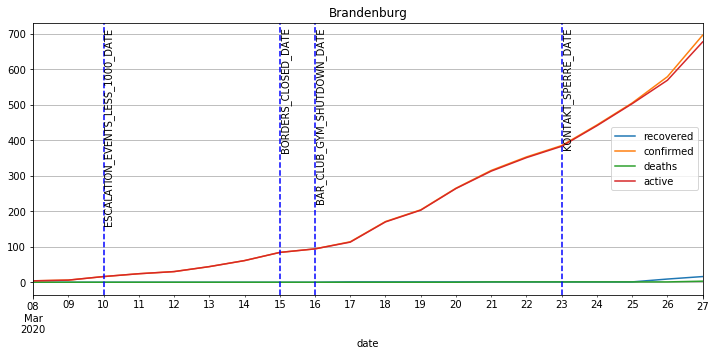

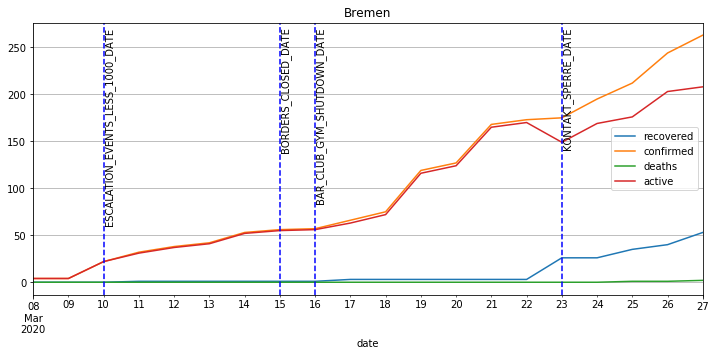

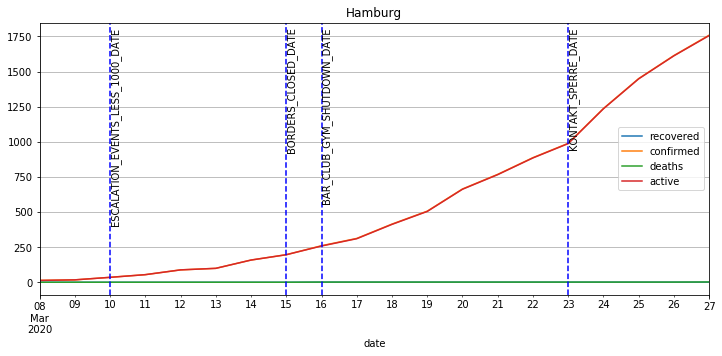

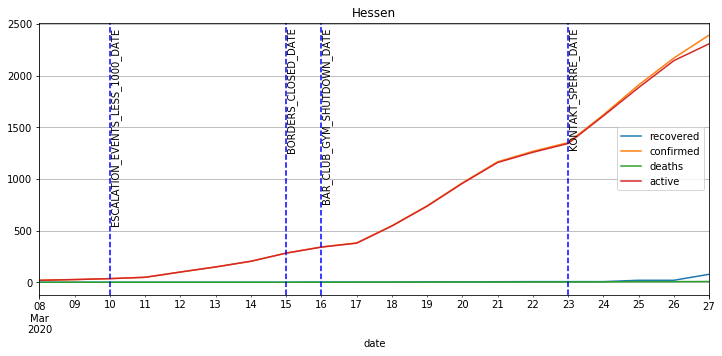

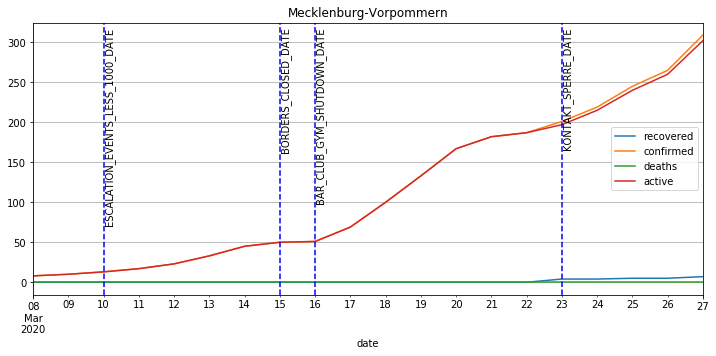

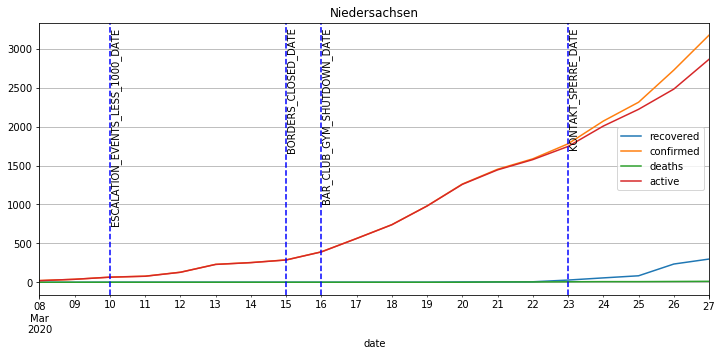

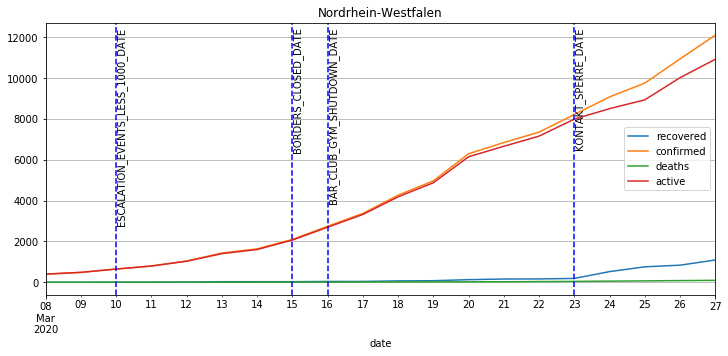

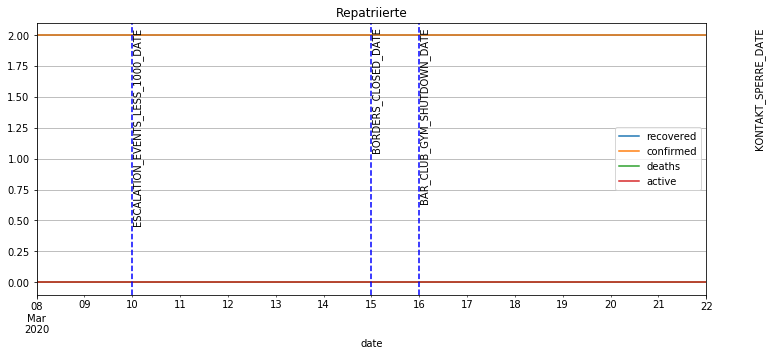

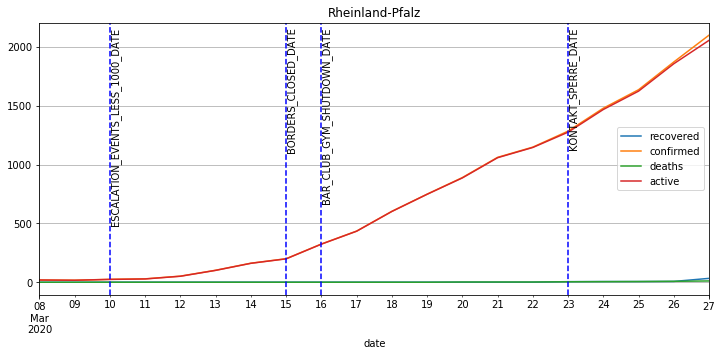

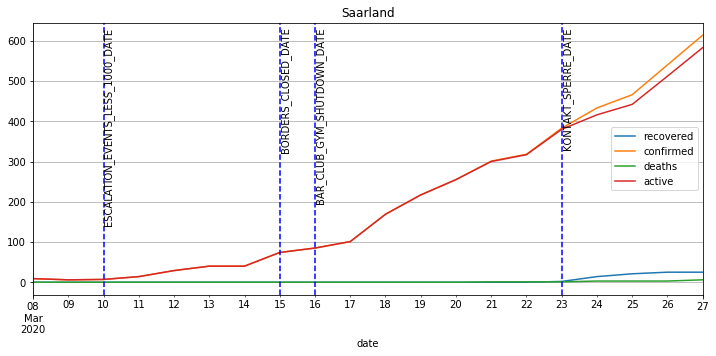

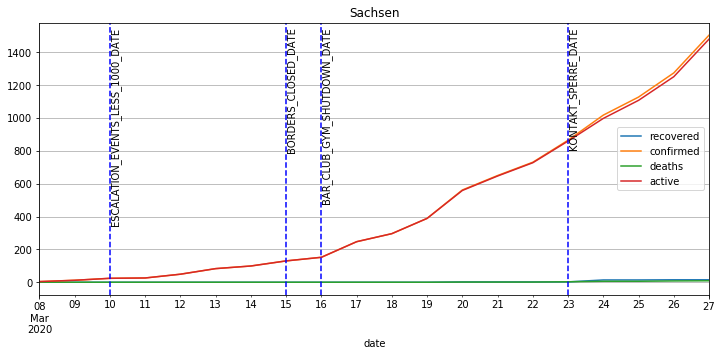

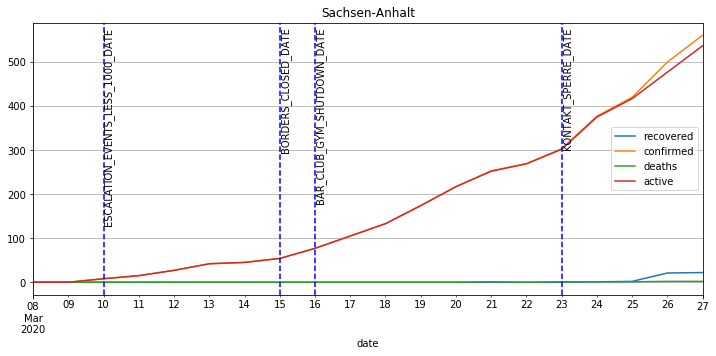

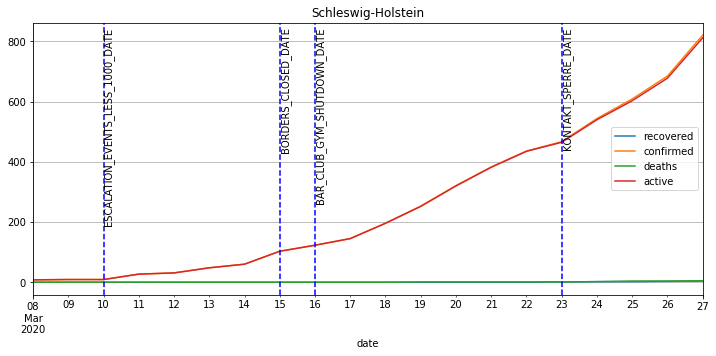

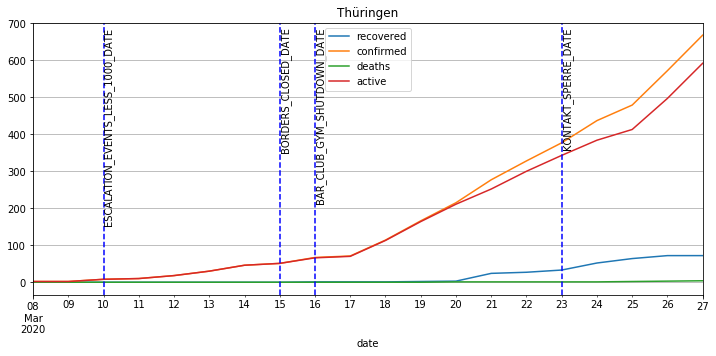

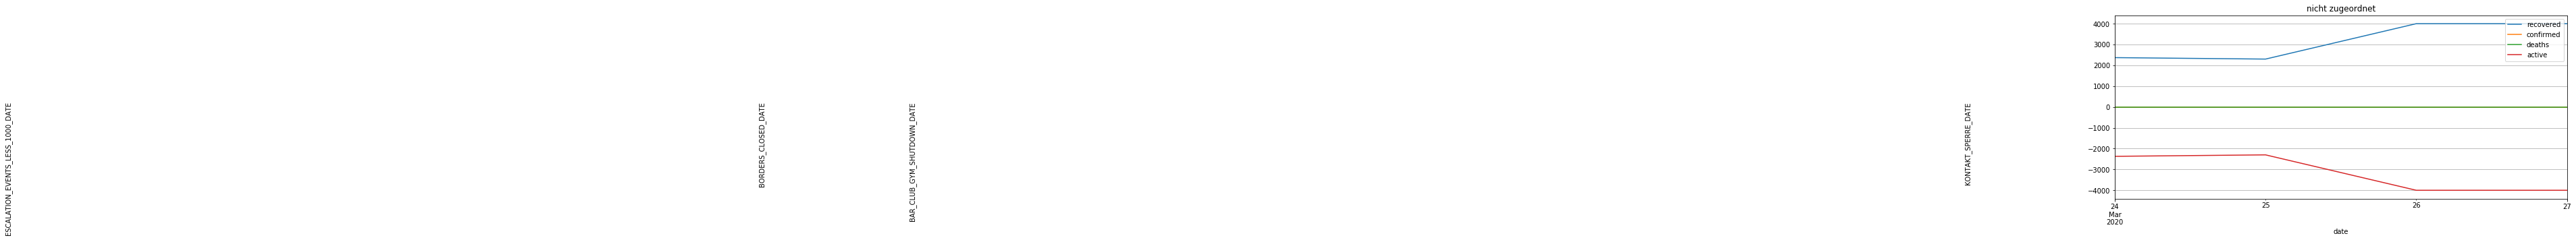

In [20]:
for fed in feds:
    df = de_fed_by_date.loc[de_fed_by_date.label==fed].set_index('date')
    ax = df.plot(figsize=(12,5), title=fed)
    plot_events(ax,df.confirmed.max().max())
    pyplot.grid(True)

## Fed Cases per 10000 Inhabitants

In [21]:
PER_INHABITANTS = 100000

In [22]:
de_fed_by_date_w_inhabitants = pd.merge(de_fed_by_date.rename ({"label":"Bundesland"}, axis=1), fed_inhabitants_2018, on='Bundesland', how='inner').set_index(['date','Bundesland'])

### Confirmed

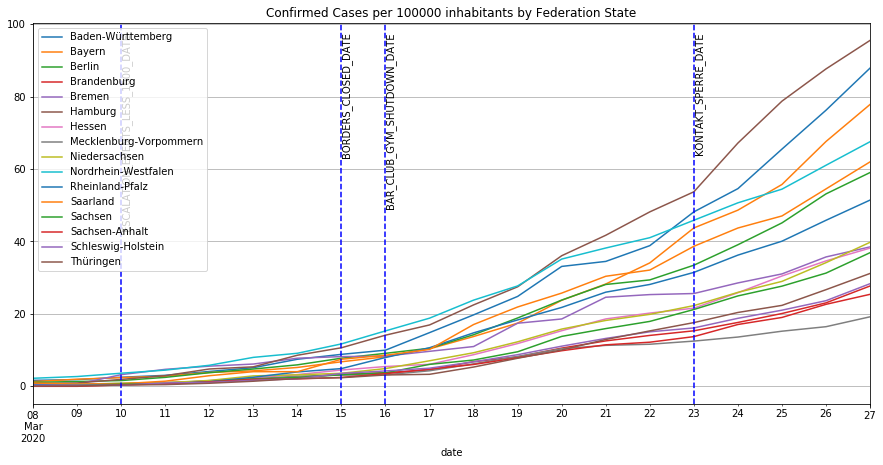

In [23]:
confirmed_per_inhabitants = (de_fed_by_date_w_inhabitants['confirmed']*PER_INHABITANTS)/de_fed_by_date_w_inhabitants['inhabitants_2018']

confirmed_per_inhabitants.to_frame().reset_index().set_index(['date']).groupby('Bundesland')[0].plot(figsize=(15,7), legend=True, title='Confirmed Cases per {} inhabitants by Federation State'.format(PER_INHABITANTS))
plot_events(pyplot.gca(),confirmed_per_inhabitants.max())
pyplot.grid(True);

### Active

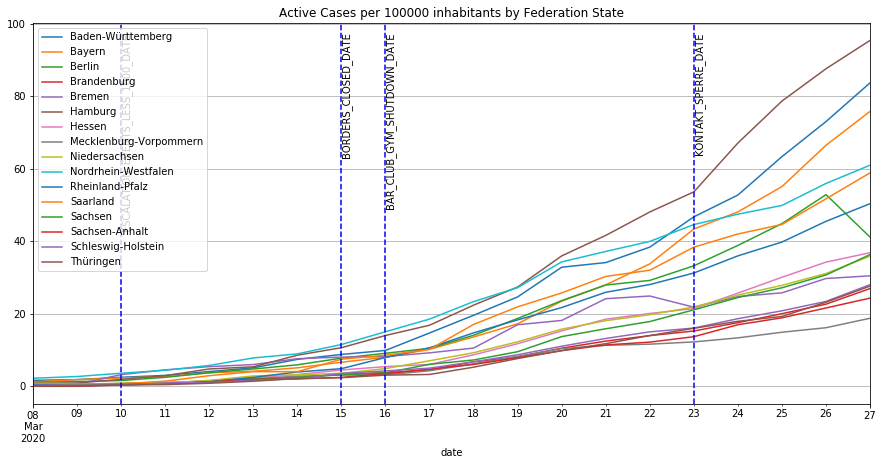

In [24]:
active_per_inhabitants = (de_fed_by_date_w_inhabitants['active']*PER_INHABITANTS)/de_fed_by_date_w_inhabitants['inhabitants_2018']

active_per_inhabitants.to_frame().reset_index().set_index(['date']).groupby('Bundesland')[0].plot(figsize=(15,7), legend=True, title='Active Cases per {} inhabitants by Federation State'.format(PER_INHABITANTS))
plot_events(pyplot.gca(),active_per_inhabitants.max())
pyplot.grid(True);

## Absolute Growth

In [25]:
confirmed_df_diff = de_fed_by_date.set_index(['date','label'])['confirmed'].unstack().diff()

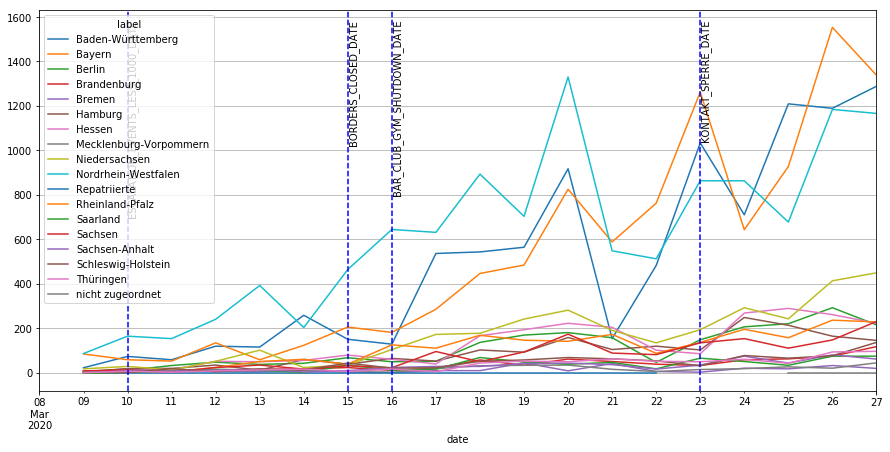

In [26]:
ax = confirmed_df_diff.plot(figsize=(15,7), legend=True)
plot_events(ax,confirmed_df_diff.max().max())
pyplot.grid(True);

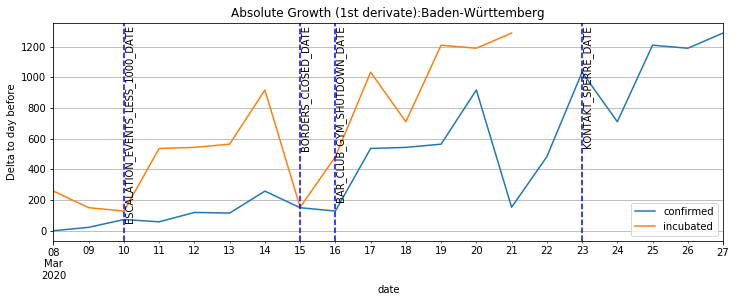

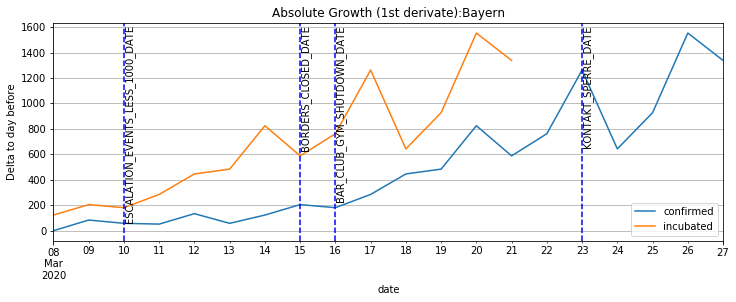

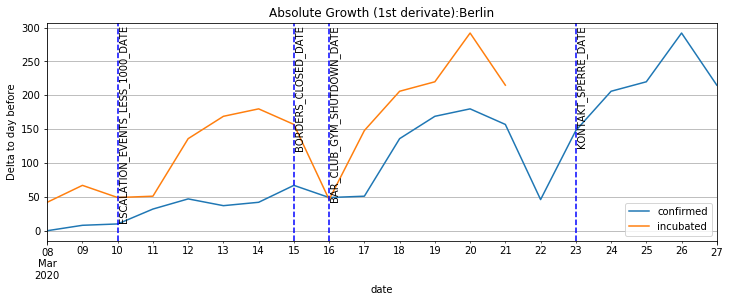

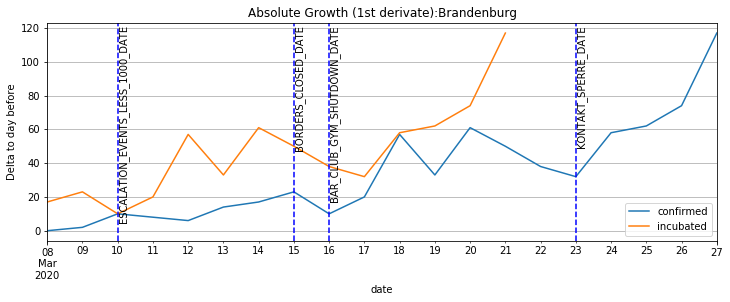

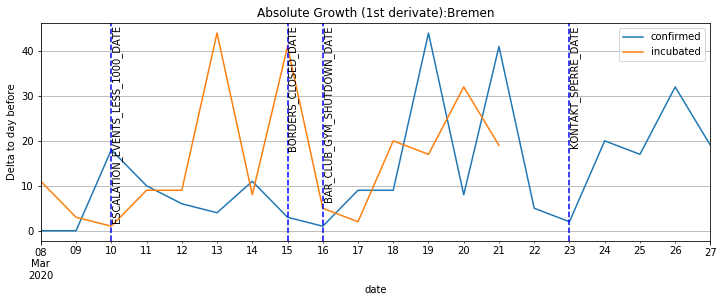

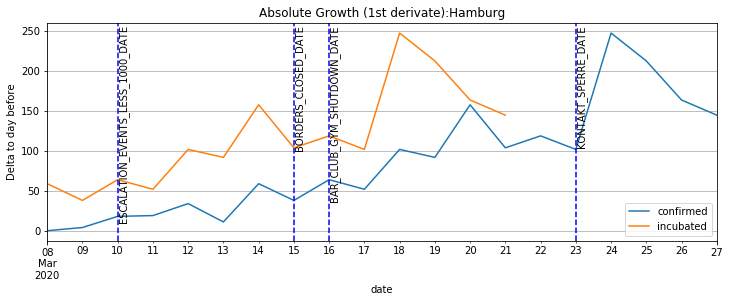

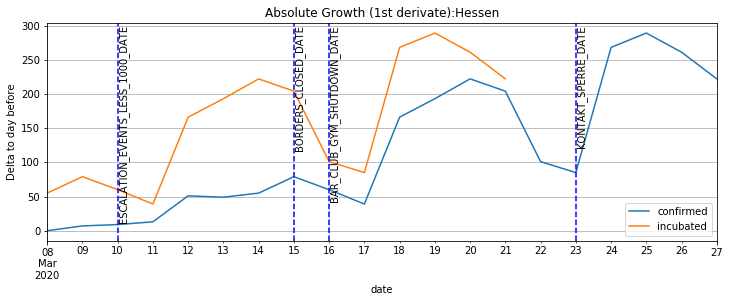

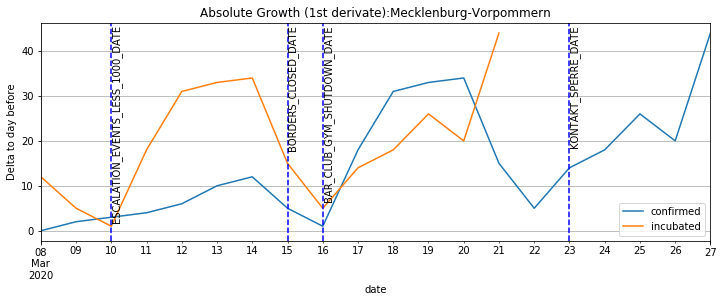

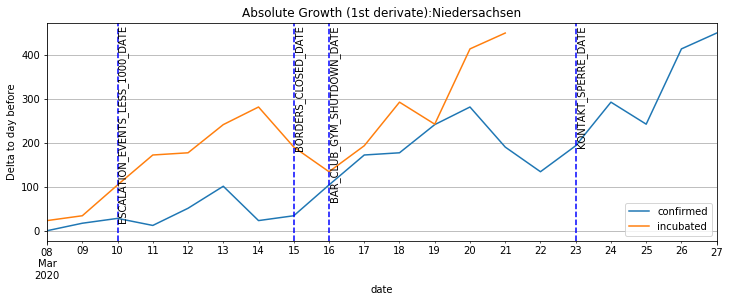

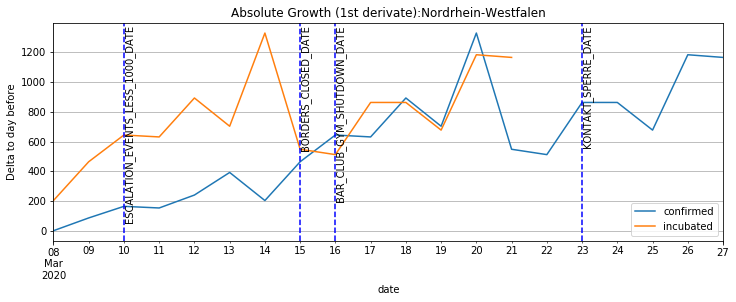

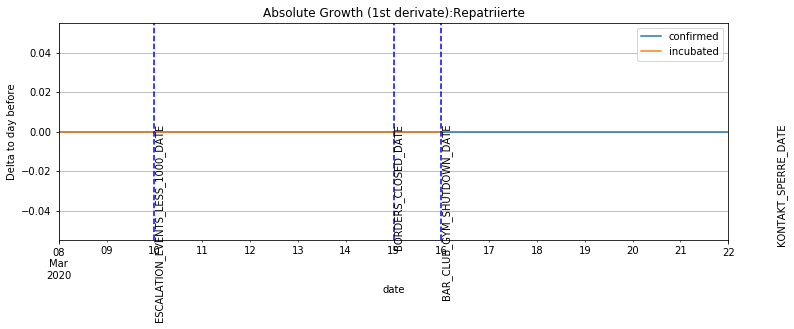

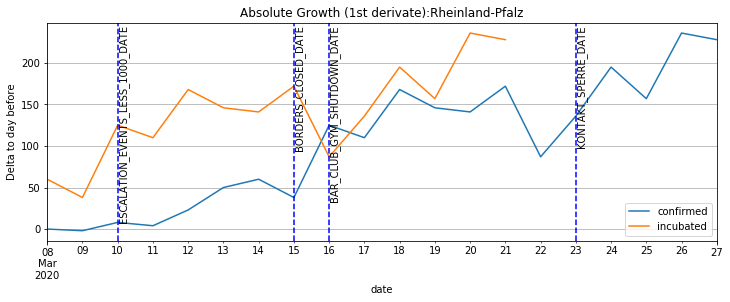

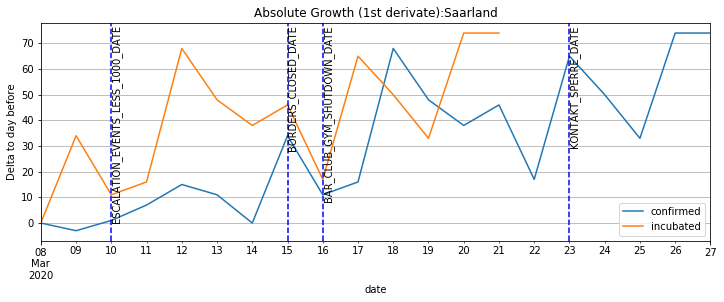

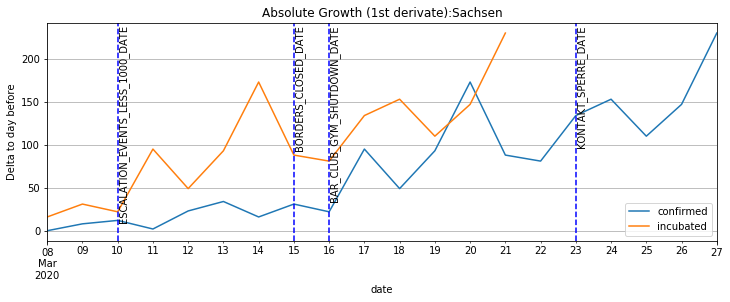

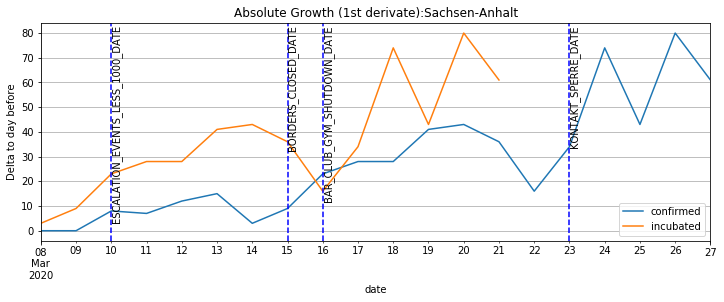

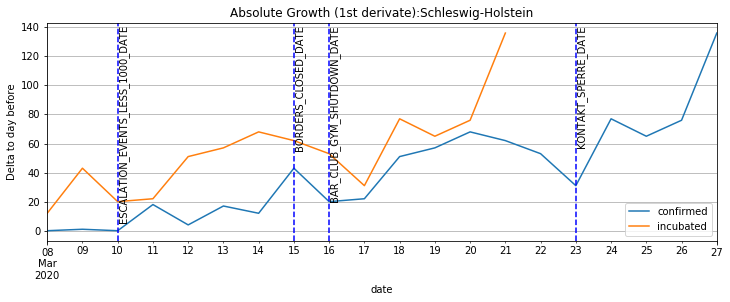

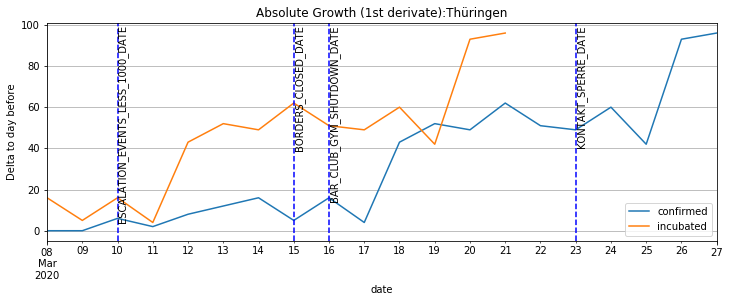

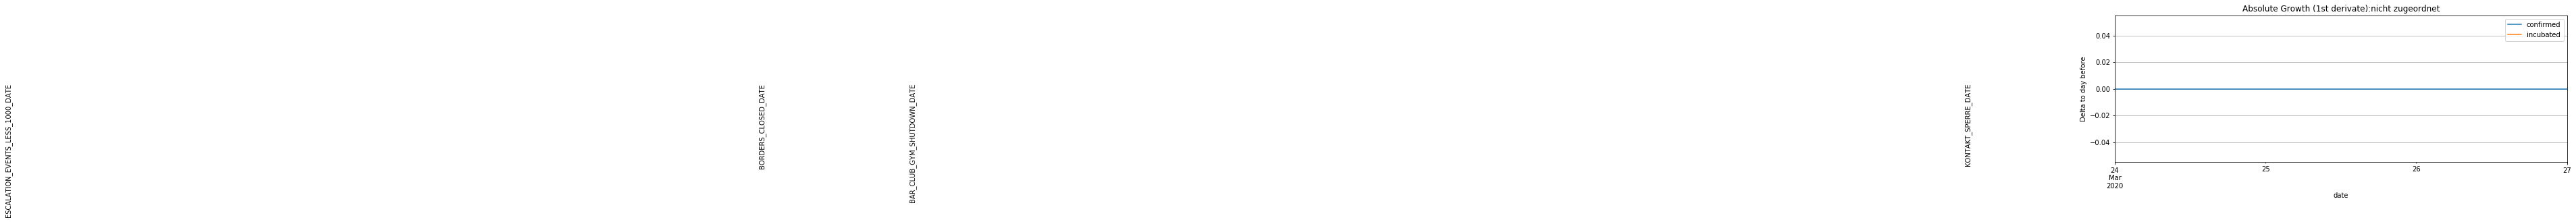

In [27]:
for fed in feds:
    fed_confirmed_by_date=de_fed_by_date.loc[de_fed_by_date.label==fed,['date','confirmed']].set_index('date')
    abs_growth = abs_growth_from(fed_confirmed_by_date)
    ax = plot_abs_growth_confirmed(abs_growth, fed)
    plot_events(ax, abs_growth.max())

## Growth Factor

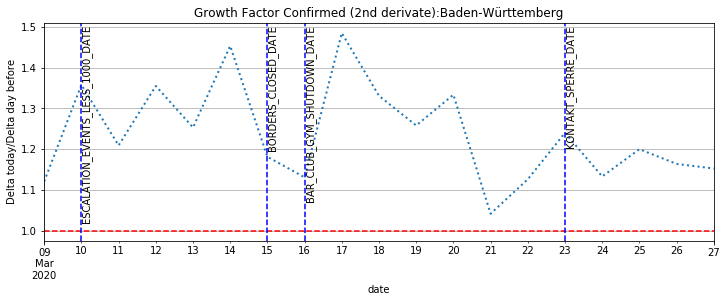

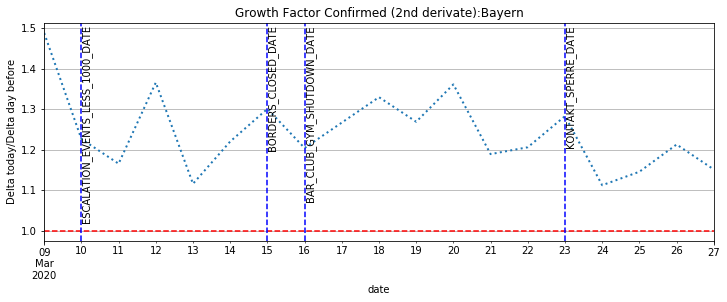

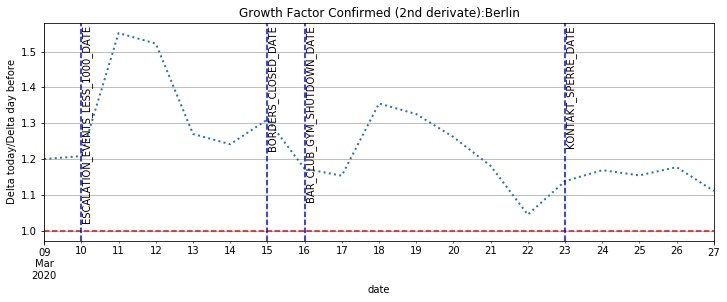

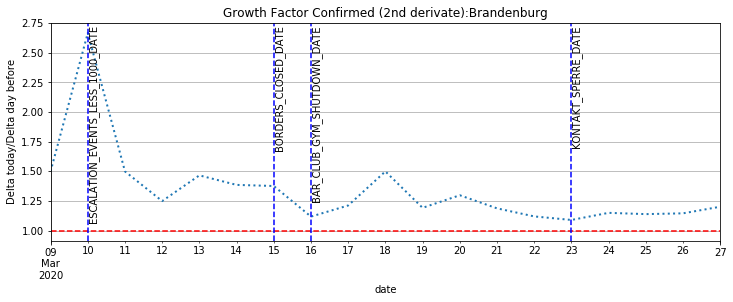

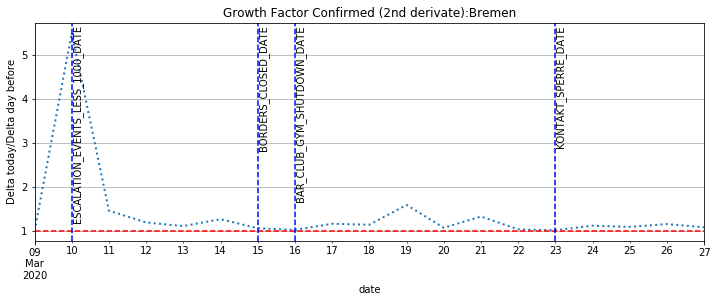

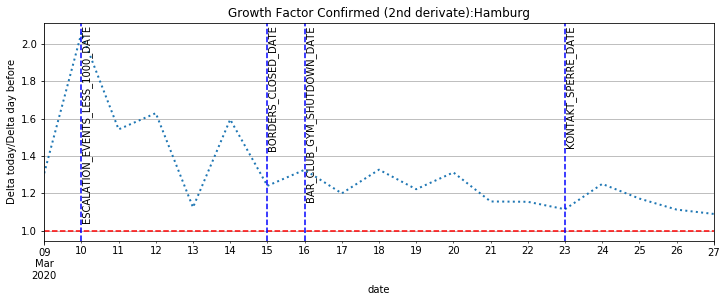

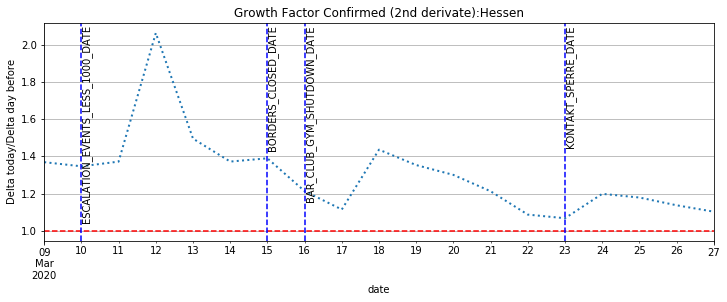

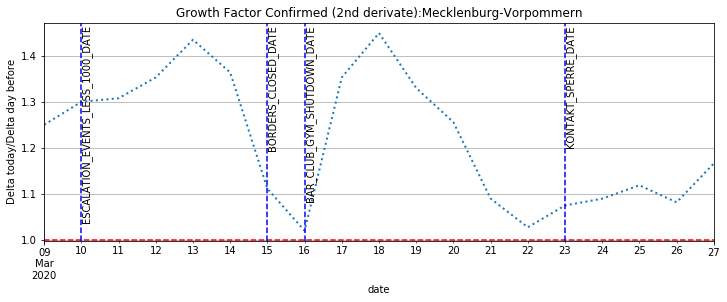

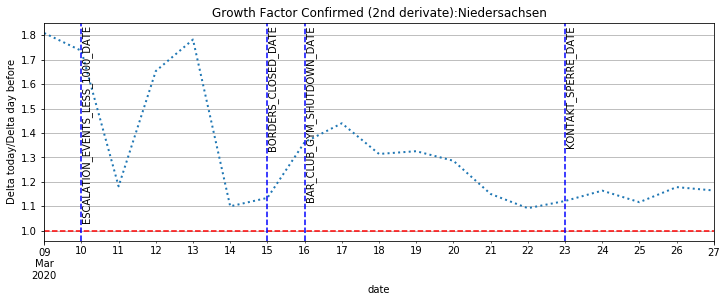

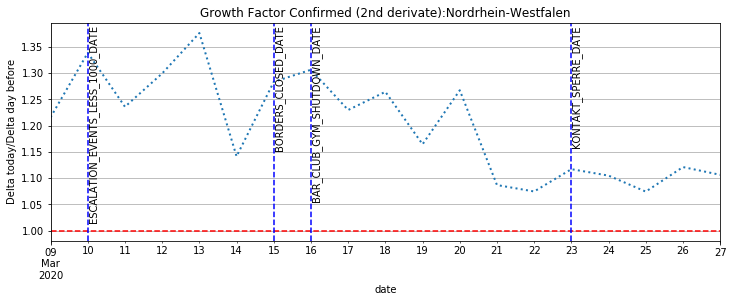

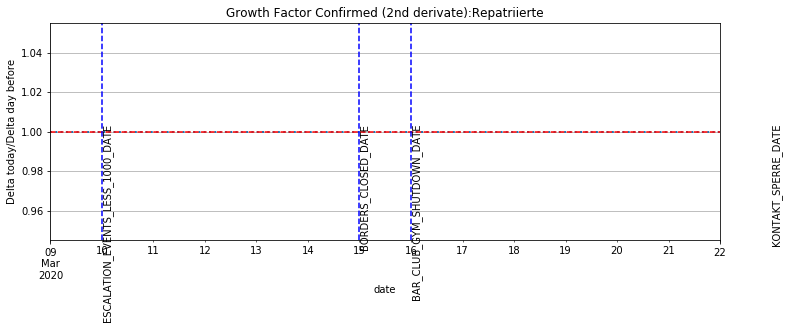

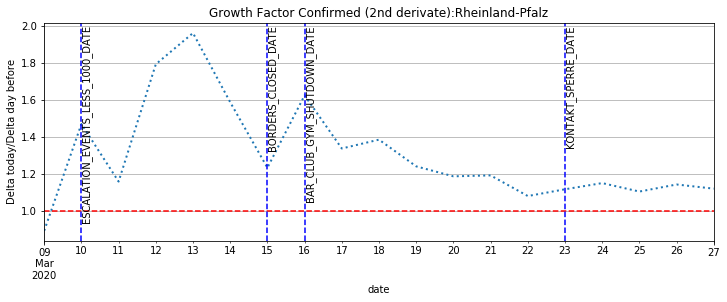

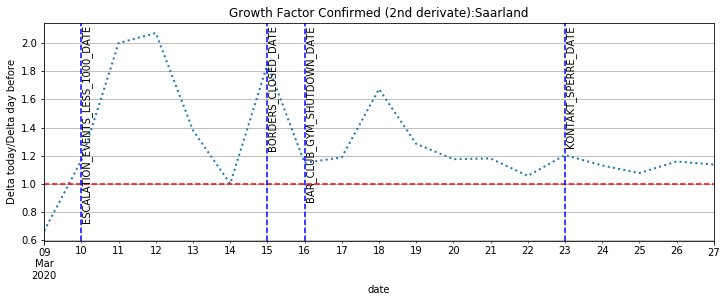

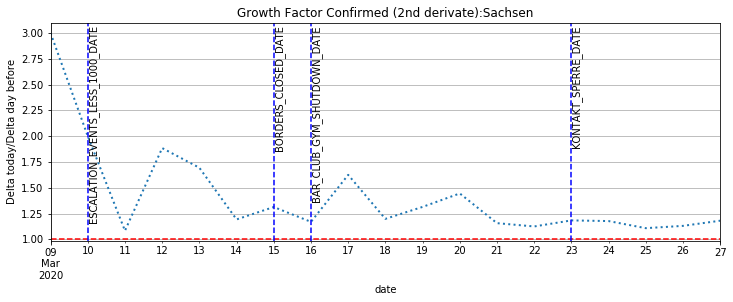

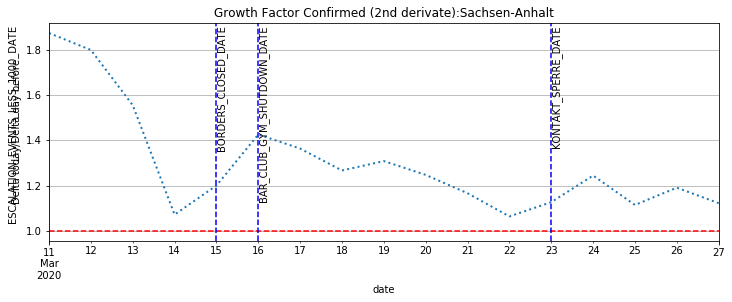

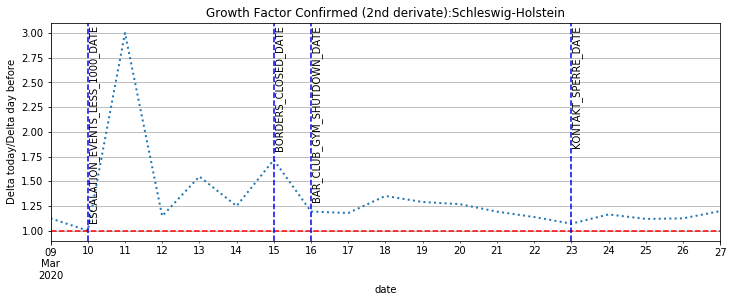

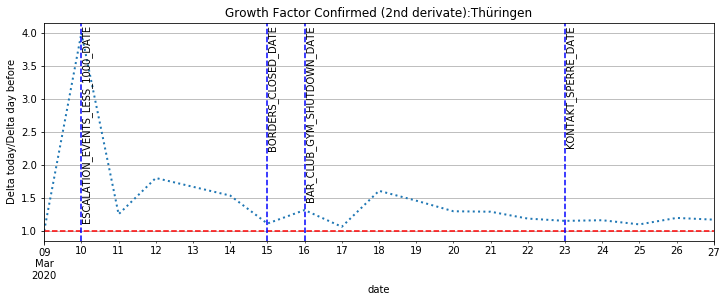

In [28]:
for fed in feds:
    fed_confirmed_by_date=de_fed_by_date.loc[de_fed_by_date.label==fed,['date','confirmed']].set_index('date')
    gf = growth_factor_from(fed_confirmed_by_date[['confirmed']])
    gf = gf[gf<1000]
    if gf.size>0:
        ax = plot_growth_factor(gf, fed)
        plot_events(ax,gf.max())
        pyplot.show()